# Comparing Mistral 7B and Mixtral 8x7B - multilabel

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import random
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory
from src.scorer import compare_models_bootstrap
from dotenv import load_dotenv
load_dotenv()
import os

In [2]:
TOGETHER_API_KEY = os.getenv("API_KEY")
BASE_URL = "https://api.together.xyz"

In [3]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

In [4]:
dataloader = DataLoader(path="../data/")
data = dataloader.get_standardized_dataframe(context_col="Text Data",
                                             target_binary_col="symptom_status_gs",
                                             target_multilabel_col="symptom_detail_gs",
                                             keep_other_cols=True)

In [5]:
Mistral7B = prompter_factory(prompter_type="multilabel",
                             client=client,
                             model="mistralai/Mistral-7B-Instruct-v0.1")
Mixtral8x7B = prompter_factory(prompter_type="multilabel",
                               client=client,
                               model="mistralai/Mixtral-8x7B-Instruct-v0.1")

In [6]:
prompt = "For each symptom in symptom list return True if present and False if absent from the transcript. \
          All symptoms required. Symptom list: 'anxiety', 'concentration problems', 'constipation', 'cough', 'diarrhea', \
          'fatigue', 'fever', 'headache', 'nausea', 'numbness and tingling', 'pain', 'poor appetite', 'rash', 'shortness \
          of breath', 'trouble drinking fluids', 'vomiting', 'other'"
context = "i have a headache every time i see a cat and i hear voices that are not there"
print(Mixtral8x7B.generate_single(prompt=prompt, context=context))

({'Anxiety': True, 'Concentration_Problems': False, 'Constipation': False, 'Cough': False, 'Diarrhea': False, 'Fatigue': False, 'Fever': False, 'Headache': True, 'Nausea': False, 'Numbness_and_Tingling': False, 'Pain': False, 'Poor_Appetite': False, 'Rash': False, 'Shortness_of_Breath': False, 'Trouble_Drinking_Fluids': False, 'Vomiting': False, 'Other': False, 'output': None}, 932)


In [7]:
prompt = "For each symptom in symptom list return True if present and False if absent from the transcript. \
          All symptoms required. Symptom list: 'anxiety', 'concentration problems', 'constipation', 'cough', 'diarrhea', \
          'fatigue', 'fever', 'headache', 'nausea', 'numbness and tingling', 'pain', 'poor appetite', 'rash', 'shortness \
          of breath', 'trouble drinking fluids', 'vomiting', 'other'"
results_mistral7b = Mistral7B.generate(df=data, prompt=prompt)
results_mixtral8x7b = Mixtral8x7B.generate(df=data, prompt=prompt)

multilabel task using: mistralai/Mistral-7B-Instruct-v0.1 - Total tokens: 0:   0%|          | 0/550 [00:00<?, ?it/s]

multilabel task using: mistralai/Mistral-7B-Instruct-v0.1 - Total tokens: 490,877: 100%|██████████| 550/550 [07:33<00:00,  1.21it/s] 
multilabel task using: mistralai/Mixtral-8x7B-Instruct-v0.1 - Total tokens: 555,516: 100%|██████████| 550/550 [11:42<00:00,  1.28s/it]  


## Model evaluation

Mistral7B


Bootstrapping Mistral7B: 100%|██████████| 1000/1000 [00:08<00:00, 113.51it/s]


accuracy: 0.3058 (0.2582-0.3567 95% CI)
precision: 0.2059 (0.163-0.2556 95% CI)
recall: 0.3729 (0.3279-0.4218 95% CI)
f1: 0.2645 (0.2238-0.3089 95% CI)
Unstructured output ratio: 0.4091 (0.3673-0.4491 95% CI)


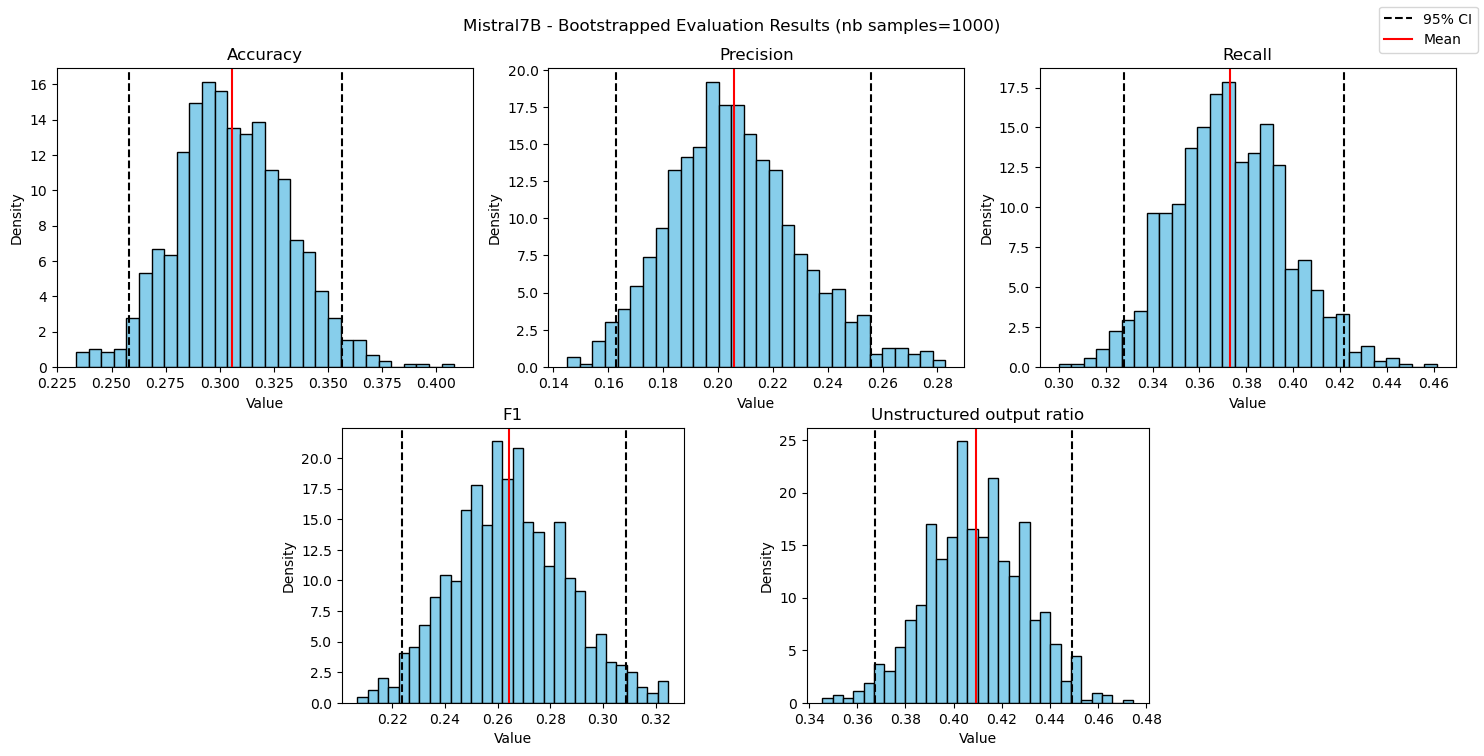

In [8]:
print("Mistral7B")
scorer_mistral7b = scorer_factory(scorer_type="multilabel", data=data, results=results_mistral7b, model_name="Mistral7B")
scorer_mistral7b.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

Mixtral8x7B


Bootstrapping Mixtral8x7B: 100%|██████████| 1000/1000 [00:09<00:00, 109.09it/s]


accuracy: 0.3818 (0.3413-0.4263 95% CI)
precision: 0.6682 (0.613-0.7238 95% CI)
recall: 0.394 (0.3552-0.4355 95% CI)
f1: 0.4953 (0.4588-0.5345 95% CI)
Unstructured output ratio: 0.0821 (0.0618-0.1055 95% CI)


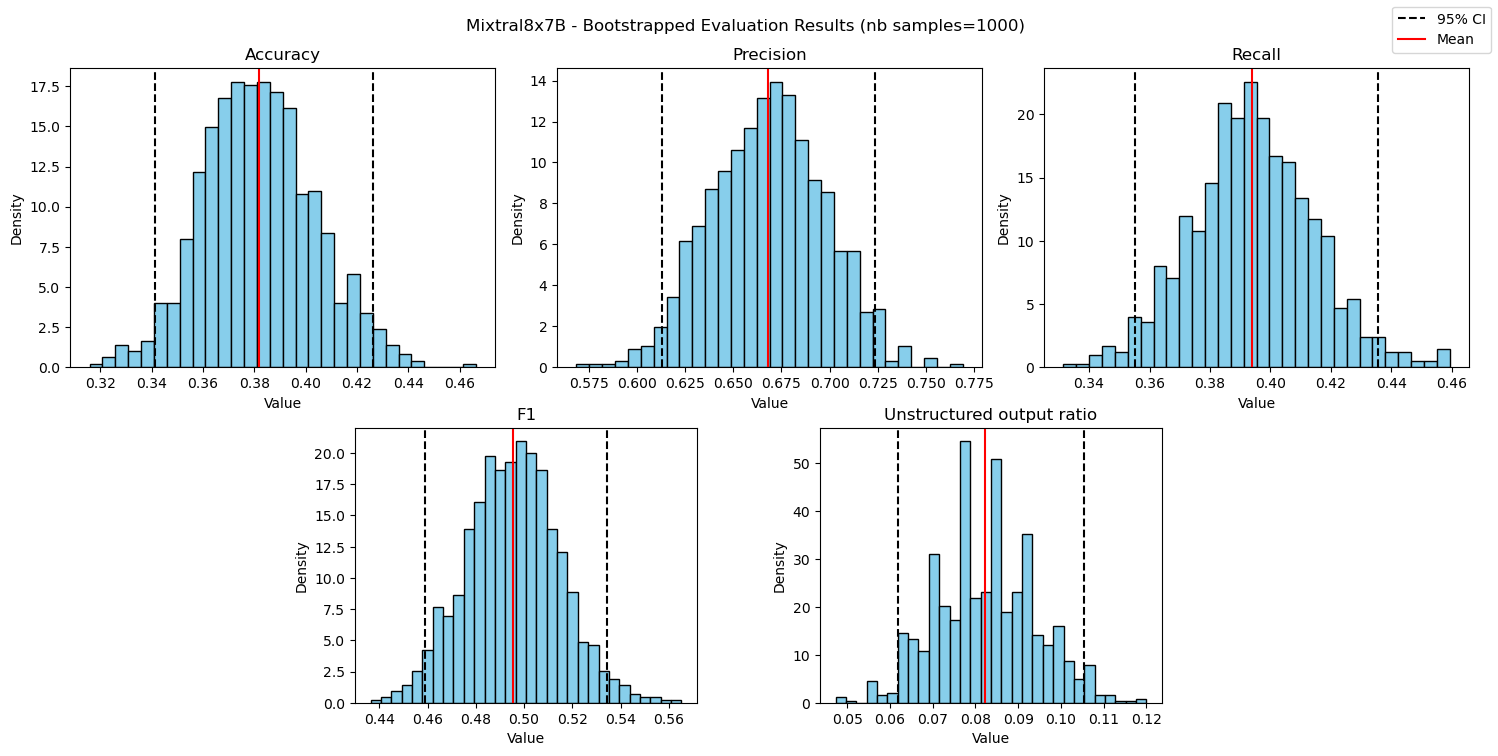

In [9]:
print("Mixtral8x7B")
scorer_mixtral8x7b = scorer_factory(scorer_type="multilabel", data=data, results=results_mixtral8x7b, model_name="Mixtral8x7B")
scorer_mixtral8x7b.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

Bootstrapping Mixtral8x7B: 100%|██████████| 1000/1000 [00:08<00:00, 111.20it/s]


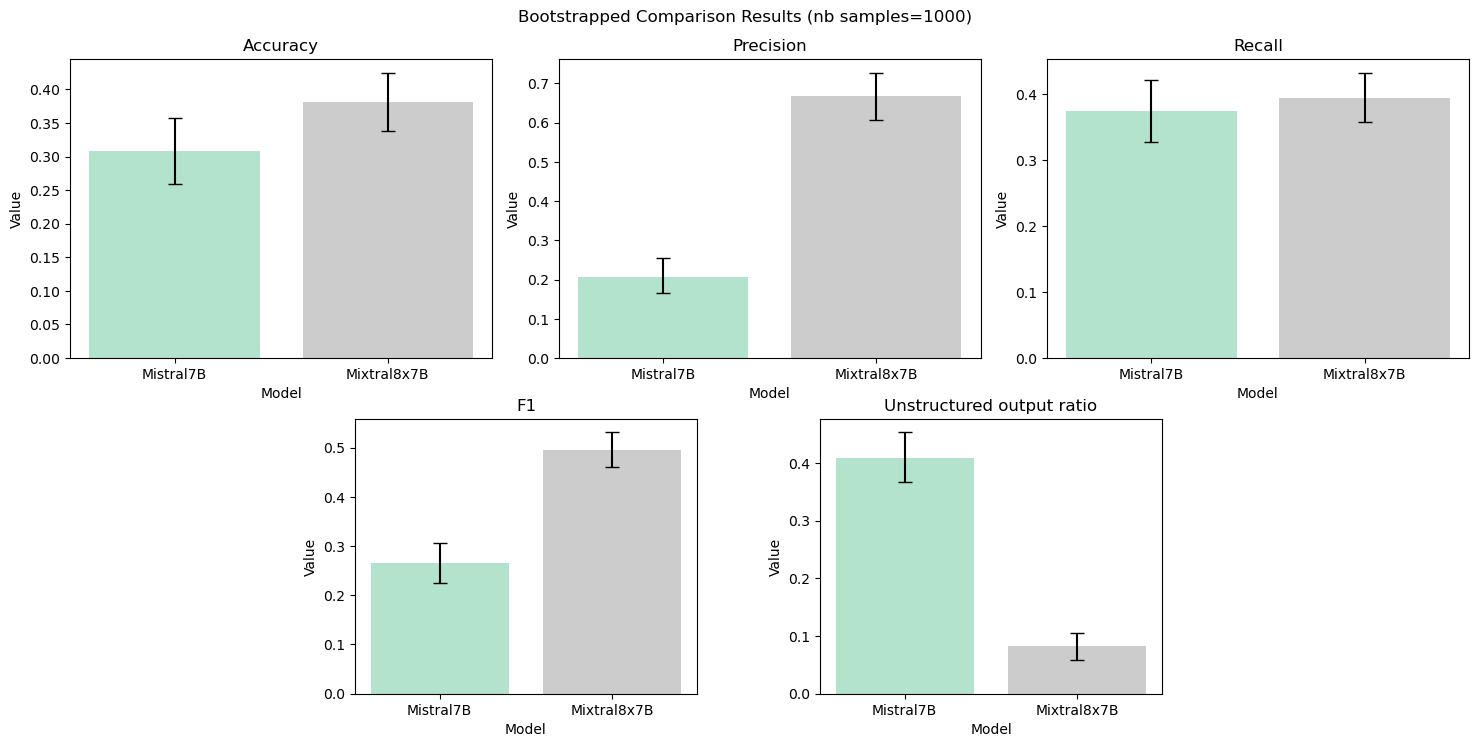

In [10]:
dict_scorers = {"Mistral7B": scorer_mistral7b, "Mixtral8x7B": scorer_mixtral8x7b}
compare_models_bootstrap(dict_scorers=dict_scorers, sample_size=len(data), n_samples=1000)

## Error Interrogation

In [11]:
df_mistral7b_error = scorer_mistral7b.get_error_dataframe()
df_mistral8x7b_error = scorer_mixtral8x7b.get_error_dataframe()

In [13]:
selected_columns = df_mistral7b_error.columns[:df_mistral7b_error.columns.get_loc("Target binary")].to_list() + scorer_mistral7b.pred_columns.to_list() + scorer_mistral7b.target_columns.to_list()
df_mistral7b_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,...,Target headache,Target nausea,Target numbness and tingling,Target pain,Target poor appetite,Target rash,Target shortness of breath,Target trouble drinking fluids,Target vomiting,Target other
count,450,223,170,450,450,338,450,112,112,16,...,450,450,450,450,450,450,450,450,450,450
unique,450,2,92,50,2,141,50,30,68,2,...,2,2,2,2,2,2,2,2,2,2
top,"D: How may I help you?\n\nP: Hi, umm, so I've ...",Positive,Other,RES0022.txt,Positive,Other,RES0022.txt,Other,pain,Negative;Positive,...,False,False,False,False,False,False,False,False,False,True
freq,1,169,16,16,338,34,16,30,9,10,...,401,411,427,278,421,412,371,447,411,266


In [21]:
df_mistral7b_error.loc[:, "Concatenated"] = df_mistral7b_error.apply(
    lambda row: f"index: {row.name}\n\nContext: {row['Context']}\n\n\nModel Prediction:\n{row[scorer_mistral7b.pred_columns]}",
    axis=1
)
# Converting to a list makes for an easier way to print the results
contexts_mistral7b = df_mistral7b_error["Concatenated"].to_list()

In [15]:
random.shuffle(contexts_mistral7b)
print(contexts_mistral7b[0])

index: 200

Context: P: OK yeah, that sounds great. Thank you.

D: Yeah, no problem.


Model Prediction:
Pred Anxiety                    NaN
Pred Concentration_Problems     NaN
Pred Constipation               NaN
Pred Cough                      NaN
Pred Diarrhea                   NaN
Pred Fatigue                    NaN
Pred Fever                      NaN
Pred Headache                   NaN
Pred Nausea                     NaN
Pred Numbness_and_Tingling      NaN
Pred Pain                       NaN
Pred Poor_Appetite              NaN
Pred Rash                       NaN
Pred Shortness_of_Breath        NaN
Pred Trouble_Drinking_Fluids    NaN
Pred Vomiting                   NaN
Pred Other                      NaN
Name: 200, dtype: object


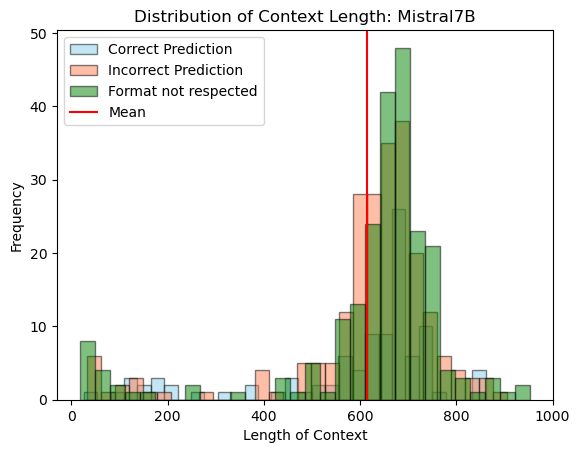

In [16]:
scorer_mistral7b.display_length_distribution()

In [17]:
selected_columns = df_mistral8x7b_error.columns[:df_mistral8x7b_error.columns.get_loc("Target binary")].to_list() + scorer_mixtral8x7b.pred_columns.to_list() + scorer_mixtral8x7b.target_columns.to_list()
df_mistral8x7b_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,...,Target headache,Target nausea,Target numbness and tingling,Target pain,Target poor appetite,Target rash,Target shortness of breath,Target trouble drinking fluids,Target vomiting,Target other
count,357,175,151,357,357,304,357,101,101,16,...,357,357,357,357,357,357,357,357,357,357
unique,357,2,85,50,2,132,50,27,62,2,...,2,2,2,2,2,2,2,2,2,2
top,"D: How may I help you?\n\nP: Hi, umm, so I've ...",Positive,Other,RES0022.txt,Positive,Other,RES0022.txt,Other,NONE,Negative;Positive,...,False,False,False,False,False,False,False,False,False,True
freq,1,150,15,12,304,34,12,23,8,11,...,312,319,335,208,330,321,282,355,318,264


In [22]:
df_mistral8x7b_error.loc[:, "Concatenated"] = df_mistral8x7b_error.apply(
    lambda row: f"index: {row.name}\n\nContext: {row['Context']}\n\n\nModel Prediction:\n{row[scorer_mixtral8x7b.pred_columns]}",
    axis=1
)
# Converting to a list makes for an easier way to print the results
contexts_mixtral8x7b = df_mistral8x7b_error["Concatenated"].to_list()

In [19]:
random.shuffle(contexts_mixtral8x7b)
print(contexts_mixtral8x7b[0])

index: 319

Context: D: OK and did anything happened prior to the pain, any injuries at all that you experienced?

P: Two months ago I was in a motor vehicle accident um an I think my back started hurting then but they did some imaging it's and turned out like one of the discs there was a slip in a disc or something, but at that point the pain was just achey and I don't really have any in any of these other issues. But over the past two weeks it's gotten sharp and I'm having all these other symptoms.

D: OK, um and. So you're having the set like what's called, some numbness in your groin. Is that unilateral, like on one side or both sides?

P: Uhm, it seems like it's both sides.

D: OK, and. So and then you're also having the urinary incontinence. How long is that been going on for?

P: The past week.


Model Prediction:
Pred Anxiety                    False
Pred Concentration_Problems     False
Pred Constipation               False
Pred Cough                      False
Pred Diarrhea  

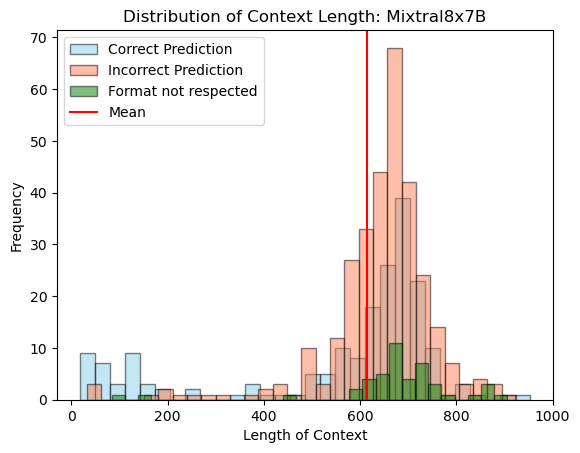

In [20]:
scorer_mixtral8x7b.display_length_distribution()